### **Importing Required Libraries**

In [109]:
import cv2
from matplotlib import pyplot as plt
from keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG19
import os

### **Loading Train Image and Test Image Data**

In [115]:
# Using the ImageDataGenerator technique to load the data

# Creating the train and test ImageDataGenerator instances
train_image_data_generator = ImageDataGenerator(
    rescale = 1./255
)

test_image_data_generator = ImageDataGenerator(
    rescale = 1./255
)

# Specifying the train directory and test directory inside a variable to use in different functions
train_directory = r'C:\Users\njain\OneDrive - Cal State Fullerton\SPRING 2024\CPSC 597 Project\Project\APMBSS\data\raw\face_detection\train'
test_directory = r'C:\Users\njain\OneDrive - Cal State Fullerton\SPRING 2024\CPSC 597 Project\Project\APMBSS\data\raw\face_detection\test'

# Loading the train data using flow_from_directory() method using `train_image_data_generator`
training_data = train_image_data_generator.flow_from_directory(
    directory = train_directory,
    target_size = (48, 48),
    batch_size = 64,
    color_mode = 'rgb',
    class_mode = 'categorical'
)

# Loading the test data using flow_from_directory() method using `test_image_data_generator`
testing_data = test_image_data_generator.flow_from_directory(
    directory = test_directory,
    target_size = (48, 48),
    batch_size = 64,
    color_mode = 'rgb',
    class_mode = 'categorical'
)

Found 21522 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.


### **Visualising the Images**

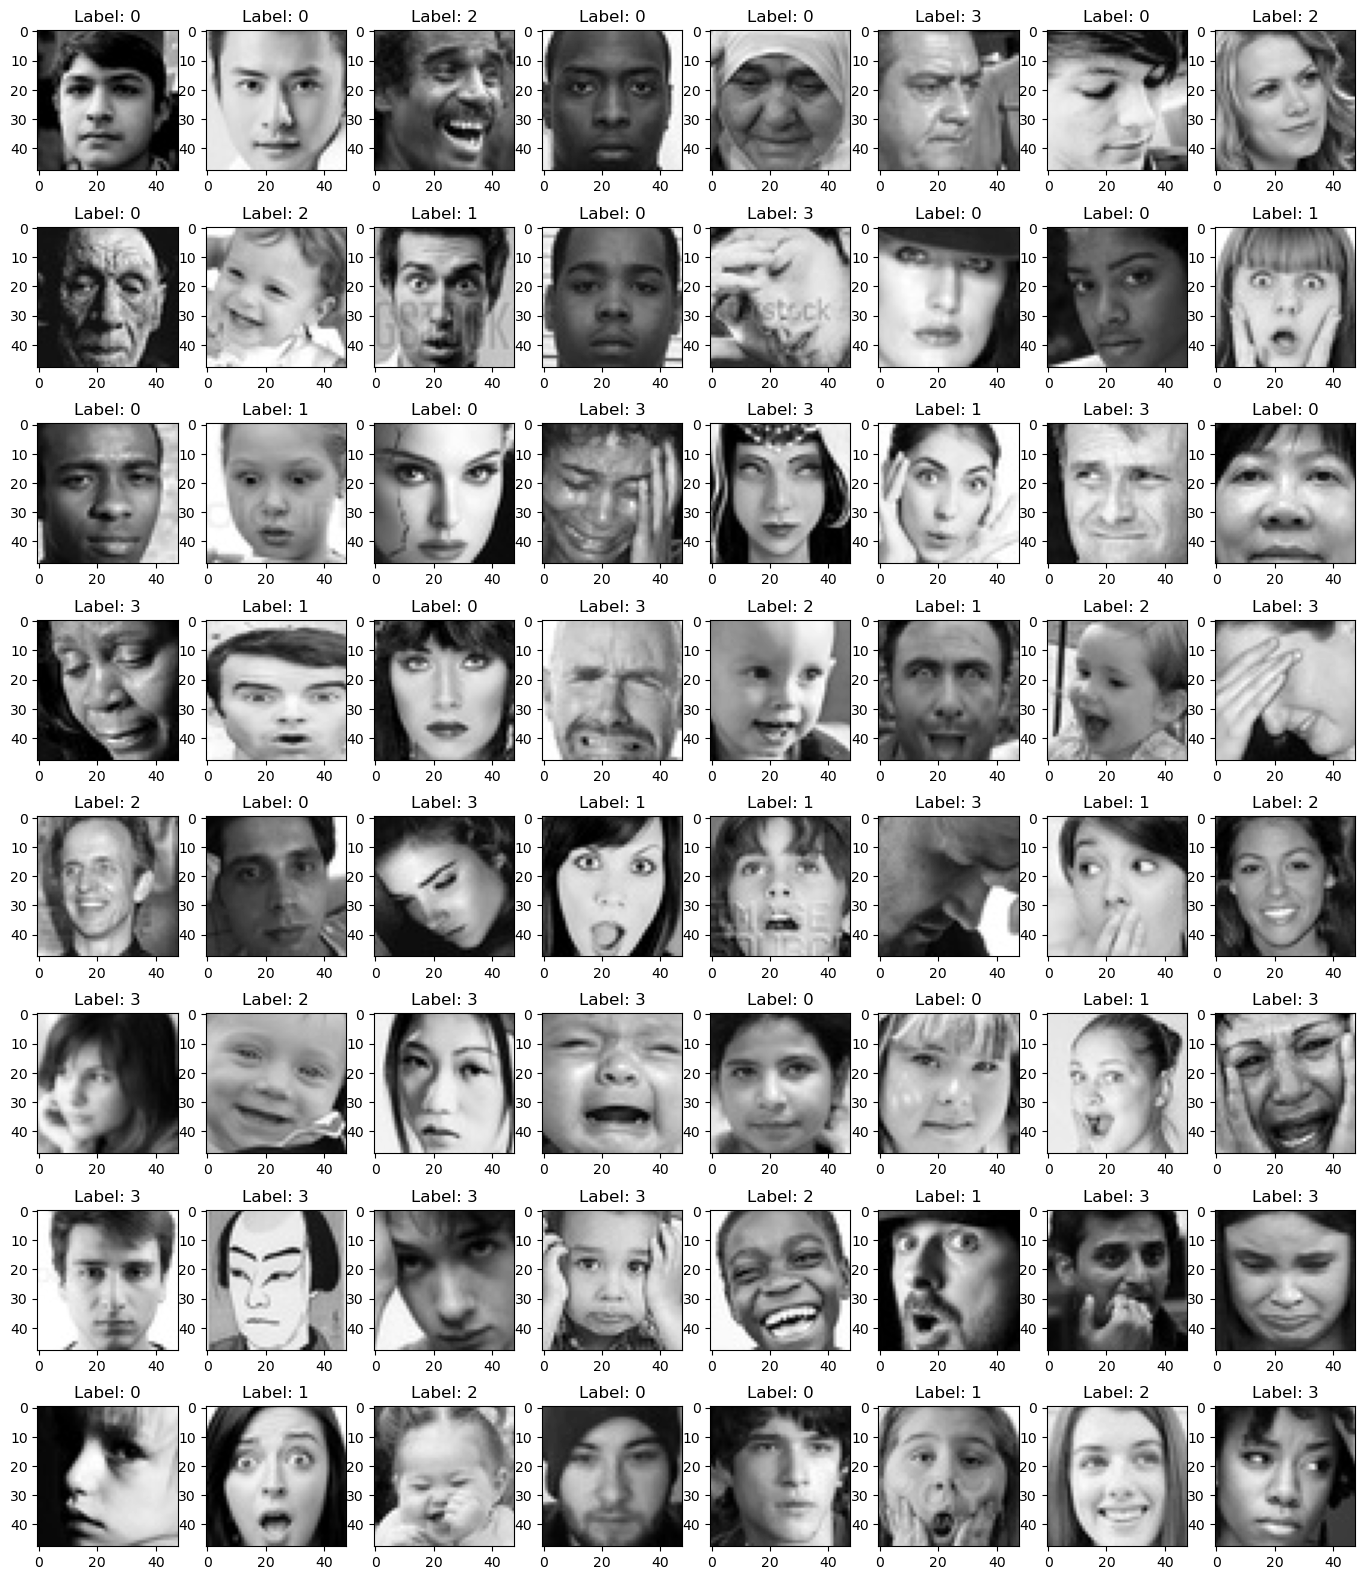

'\nBelow can be concluded from below:\nLabel 0: Calm\nLabel 1: Energetic\nLabel 2: Happy\nLabel 3: Sad\n'

In [60]:
# Getting a batch of images using next() function
sample_images, labels = next(training_data)

# Number of images to display
num_images = len(sample_images)

# Extract folder names from the generator's filenames
folder_names = [os.path.dirname(file) for file in training_data.filenames[:num_images]]

# Plotting the images using matplotlib
plt.figure(figsize =(17, 20))
for i in range(0, num_images):
    plt.subplot(8, 8, i + 1)
    plt.imshow(sample_images[i], cmap='gray')
    plt.title(f"Label: {labels[i].argmax()}")  # Display the one-hot encoded label

plt.show()

'''
Below can be concluded from below:
Label 0: Calm
Label 1: Energetic
Label 2: Happy
Label 3: Sad
'''

### **Plotting the Bar Graph Representing the Number of Items Inside the Categories Using Matplotlib**

#### **Train Data Plotting**

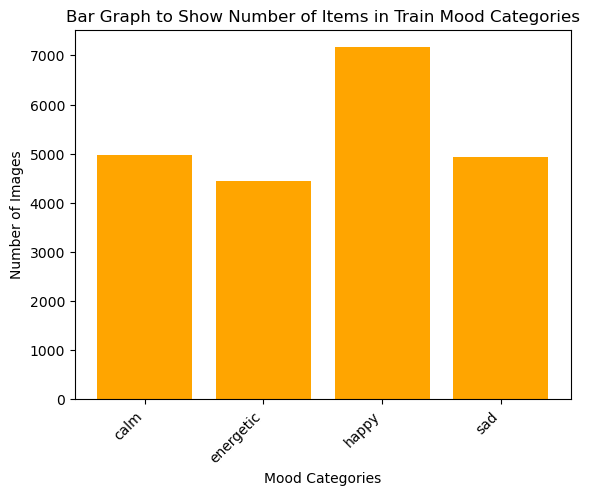

In [61]:
# Already defined the train directory path as train_directory
train_folders = [ folder for folder in os.listdir(train_directory) if os.path.isdir(os.path.join(train_directory, folder))]

folder_names_train = []
item_counts_train = []

for folder in train_folders:
    folder_path = os.path.join(train_directory, folder)
    num_items = len(os.listdir(folder_path))
    folder_names_train.append(folder)
    item_counts_train.append(num_items)

# Create a bar graph
plt.bar(folder_names_train, item_counts_train, color='orange')
plt.xlabel('Mood Categories')
plt.ylabel('Number of Images')
plt.title('Bar Graph to Show Number of Items in Train Mood Categories')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

#### **Train Data Plotting**

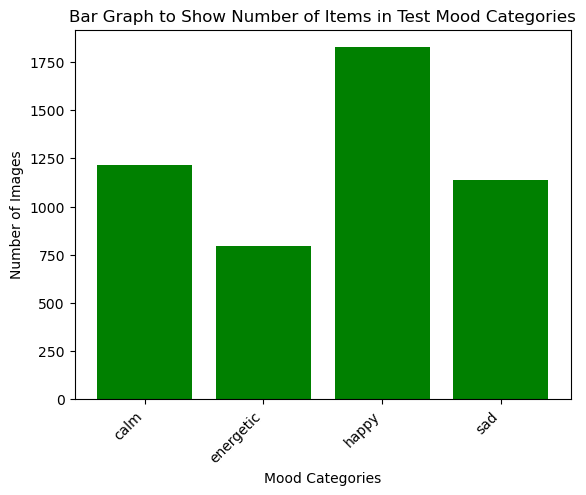

In [62]:
# Already defined the test directory path as test_directory path
test_folders = [ folder for folder in os.listdir(test_directory) if os.path.isdir(os.path.join(test_directory, folder))]

folder_names_test = []
item_counts_test = []

for folder in test_folders:
    folder_path = os.path.join(test_directory, folder)
    num_items = len(os.listdir(folder_path))
    folder_names_test.append(folder)
    item_counts_test.append(num_items)

# Create a bar graph
plt.bar(folder_names_test, item_counts_test, color='green')
plt.xlabel('Mood Categories')
plt.ylabel('Number of Images')
plt.title('Bar Graph to Show Number of Items in Test Mood Categories')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.show()

### **Preprocessing The Data**

### **Create a CNN Model For Image Classification**

In [76]:
# Initializing the Sequential model of tensorflow to create a layered structure of CNN model
mood_detection_modle = Sequential()

## Creating CNN layers
# Layer 1 - Input Layer:
mood_detection_modle.add(Conv2D(
    32,
    kernel_size = (3, 3),
    activation = 'relu',
    input_shape = (48, 48, 1)
    # padding = 'same'
))
# Adding a MaxPooling2D layer to reduce the spetial dimentions of the feature maps to retain important features
mood_detection_modle.add(MaxPooling2D(pool_size = (2, 2)))
# Adding a DROPOUT layer to reduce the chances of overfitting
mood_detection_modle.add(Dropout(0.20))

# Layer 2:
mood_detection_modle.add(Conv2D(
    64,
    kernel_size = (3, 3),
    activation = 'relu'
))
# Adding a MaxPooling2D layer to reduce the spetial dimentions of the feature maps to retain important features
mood_detection_modle.add(MaxPooling2D(pool_size = (2, 2)))

# Layer 3:
mood_detection_modle.add(Conv2D(
    128,
    kernel_size = (3, 3),
    activation = 'relu'
))
# Adding a MaxPooling2D layer to reduce the spetial dimentions of the feature maps to retain important features
mood_detection_modle.add(MaxPooling2D(pool_size = (2, 2)))

# Flatten Layer - For flattenning the output from the previous layer into a 1D vector
mood_detection_modle.add(Flatten())

# Adding a Dense layer
mood_detection_modle.add(Dense(
    512,
    activation = 'relu'
))
# Adding a DROPOUT layer to reduce the chances of overfitting
mood_detection_modle.add(Dropout(0.5))
mood_detection_modle.add(Dense(
    4,
    activation = 'softmax'
))

### **New Model**

In [116]:
# Load the pre-trained VGG19 model without the top (classification) layers
base_model = VGG19(weights='imagenet', include_top=False, input_shape = (48, 48, 3))

# Freeze the pre-trained layers
for layer in base_model.layers:
    layer.trainable = False

# Create a new model
mood_detection_modle = Sequential()

# Add the VGG19 base model
mood_detection_modle.add(base_model)

# Flatten the output of the VGG19 base model
mood_detection_modle.add(Flatten())

# Add your custom dense layers
mood_detection_modle.add(Dense(256, activation='relu'))
mood_detection_modle.add(Dropout(0.5))  # Optional dropout for regularization
mood_detection_modle.add(Dense(4, activation='softmax'))  # Assuming 7 classes for emotions

### **Checking the CNN Model Classifier Summary**

In [77]:
print(mood_detection_modle.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 23, 23, 32)        0         
 ng2D)                                                           
                                                                 
 dropout_38 (Dropout)        (None, 23, 23, 32)        0         
                                                                 
 conv2d_48 (Conv2D)          (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 10, 10, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (None, 8, 8, 128)       

### **Compiling the CNN Classifier Model**

In [117]:
# Setting the initial learning rate
initial_learning_rate = 0.0001

# Setting the learning rate scheduler as Exponential decay, to adaptively adjust the learning rate while training the data
learning_rate_scheduler = ExponentialDecay(
    initial_learning_rate,
    decay_steps = 100000,
    decay_rate = 0.96
    )

# Using the Adam OPTIMIZER
adam_optimizer = Adam(learning_rate = learning_rate_scheduler)

# Compiling the Model
mood_detection_modle.compile(
    loss = 'categorical_crossentropy',
    optimizer = adam_optimizer,
    metrics = ['accuracy']
)

# Display the model summary
mood_detection_modle.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_21 (Flatten)        (None, 512)               0         
                                                                 
 dense_42 (Dense)            (None, 256)               131328    
                                                                 
 dropout_46 (Dropout)        (None, 256)               0         
                                                                 
 dense_43 (Dense)            (None, 4)                 1028      
                                                                 
Total params: 20156740 (76.89 MB)
Trainable params: 132356 (517.02 KB)
Non-trainable params: 20024384 (76.39 MB)
_________________________________________________________________


### **Training the Train Data on the CNN Image Classifier Model**

In [118]:
#Adding EarlyStopping
callback = EarlyStopping(monitor='loss', patience=3)

# Fitting the training data to the CNN Classifier Model
mood_detection_modle_history = mood_detection_modle.fit_generator(
    training_data,
    steps_per_epoch = 21522 // 64,
    epochs = 30,
    validation_data = testing_data,
    validation_steps = 4977 // 64,
    callbacks = [callback]
)

Epoch 1/30


C:\Users\njain\AppData\Local\Temp\ipykernel_21820\3678394003.py:5: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  mood_detection_modle_history = mood_detection_modle.fit_generator(


 31/336 [=>............................] - ETA: 8:55 - loss: 1.5395 - accuracy: 0.2828

### **Testing the Test Data on the CNN Image Classifier**

### **Creating the Confusion Matrix**

### **Testing on Random Image to Check if CNN Classifier is able to Predict**